In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
import shutil
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


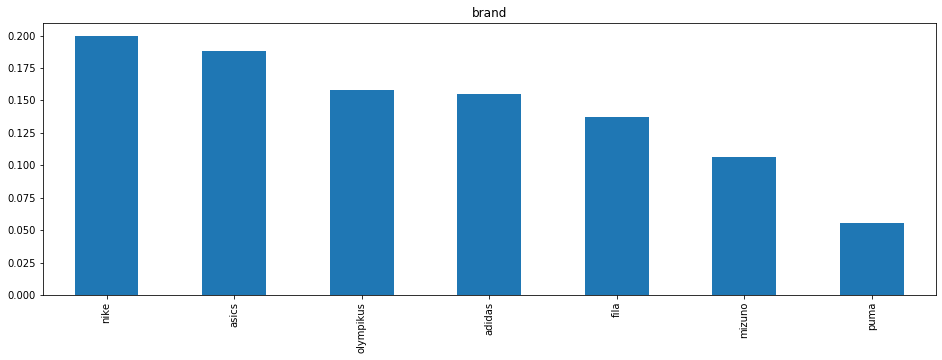

In [5]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
IMG_SHAPE = (240,240)
epochs = 100

checkpoint_path = './brand_model/drop35_lr2e4_dense256_128_64_elu_adam_weighted_b1'
# shutil.rmtree(checkpoint_path)

In [9]:
efficient_net_url = "https://tfhub.dev/google/efficientnet/b1/feature-vector/1"

drop_rate = 0.35
if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
    feature_extractor_layer.trainable = False

    model = Sequential([
        feature_extractor_layer,
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(256,'elu'),
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(128,'elu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(64,'elu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(32,'elu'),
        Dropout(0.1),
        BatchNormalization(),
        Dense(df_shoes['brand'].nunique())
    ])
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              6575232   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [10]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [11]:
batch_size = 16

train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=batch_size,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=batch_size,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=batch_size,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


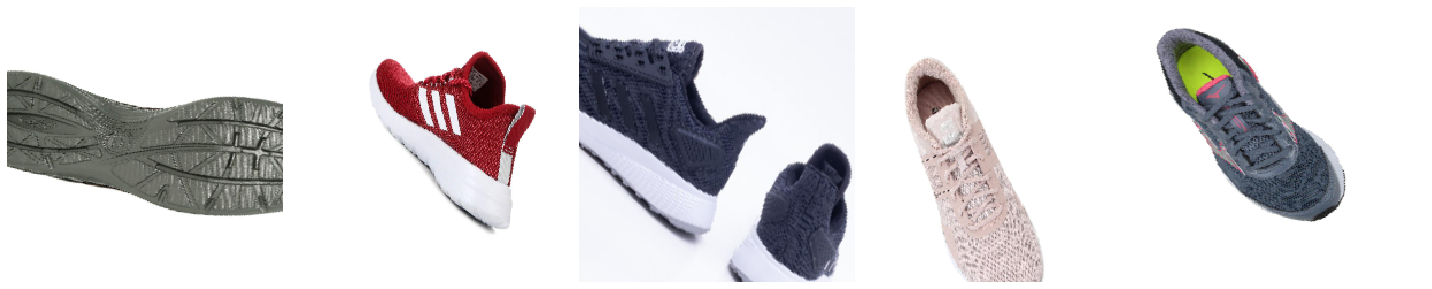

In [12]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [13]:
%tensorboard --logdir ./brand_model/drop35_lr2e4_dense256_128_64_elu_adam_weighted_b1

In [14]:
cw = list(class_weight.compute_class_weight('balanced',
                                             sorted(train['brand'].unique()),
                                             train['brand']))

cw = {idx:cw[idx] for idx,_class in enumerate(sorted(train['brand'].unique()))}

In [15]:
model.layers[0].trainable = True # fine tuning after model cannot be further improved through training

In [16]:
learning_rate = 0.0001/20

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

logdir = f"{checkpoint_path}/logs/7/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]



history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=700,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=610,
    class_weight=cw
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 929 steps, validate for 123 steps
Epoch 611/700
928/929 [============================>.] - ETA: 0s - loss: 0.5388 - acc: 0.8037WARNING:tensorflow:From /home/raphael/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./brand_model/drop35_lr2e4_dense256_128_64_elu_adam_weighted_b1/assets
929/929 [==============================] - 535s 576ms/step - loss: 0.5386 - acc: 0.8038 - val_loss: 0.2781 - val_acc: 0.9106
Epoch 612/700
929/929 [==============================] - 519s 558ms/step - loss: 0.5251 - acc: 0.8079 - val_loss: 0.2881 - val_acc: 0.9070
Epoch 613/700
929/929 [==============================] - 539s 580ms/

KeyboardInterrupt: 

In [17]:
model = tf.keras.models.load_model(checkpoint_path)

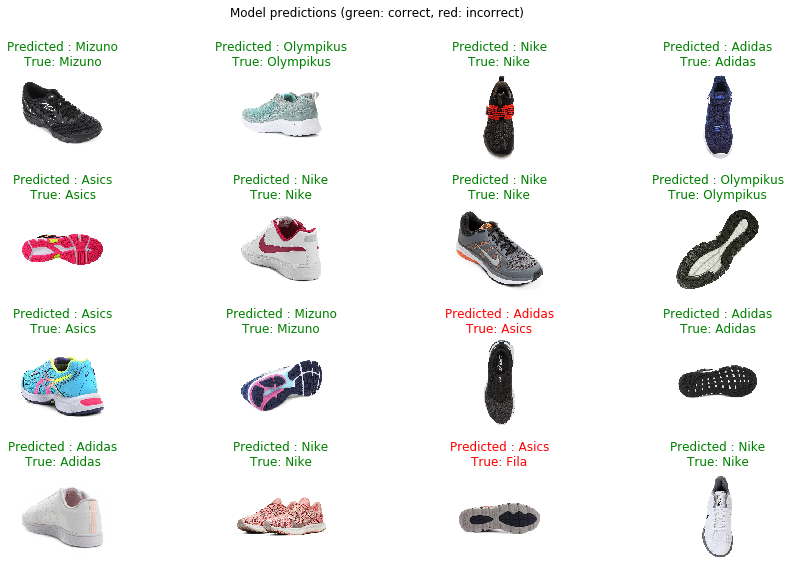

In [18]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
    plt.subplot(4,4,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [19]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']
123/123 [==============================] - 24s 197ms/step - loss: 0.2343 - acc: 0.9258
  ...
    to  
  ['...']
42/42 [==============================] - 9s 213ms/step - loss: 0.2117 - acc: 0.9300


[0.2117260571214415, 0.9299848]

Best:  
    loss: 0.2343 - acc: 0.9258  
    loss: 0.2117 - acc: 0.9300

In [20]:
def report(data_gen,model):
    real= []
    predicted = []
    steps = data_gen.samples // data_gen.batch_size
    data_gen.reset()
    for step in tqdm_notebook(range(steps)):
        image_batch, label_batch = data_gen.next()
        predicted_batch = model.predict(image_batch)

        real_id = np.argmax(label_batch,axis=-1)
        real_label_batch = class_names[real_id]

        predicted_id = np.argmax(predicted_batch, axis=-1)
        predicted_label_batch = class_names[predicted_id]

        real.extend(real_label_batch)
        predicted.extend(predicted_label_batch)

    print(classification_report(real,predicted))

In [21]:
report(val_data_gen,model)


              precision    recall  f1-score   support

      Adidas       0.89      0.92      0.91       325
       Asics       0.94      0.94      0.94       371
        Fila       0.94      0.92      0.93       260
      Mizuno       0.99      0.97      0.98       211
        Nike       0.92      0.89      0.91       394
   Olympikus       0.92      0.96      0.94       303
        Puma       0.85      0.85      0.85       104

    accuracy                           0.93      1968
   macro avg       0.92      0.92      0.92      1968
weighted avg       0.93      0.93      0.93      1968



In [22]:
report(test_data_gen,model)


              precision    recall  f1-score   support

      Adidas       0.93      0.91      0.92       108
       Asics       0.91      0.97      0.94       124
        Fila       0.94      0.93      0.94        87
      Mizuno       1.00      0.96      0.98        70
        Nike       0.94      0.86      0.90       131
   Olympikus       0.93      0.98      0.95       101
        Puma       0.82      0.91      0.86        35

    accuracy                           0.93       656
   macro avg       0.92      0.93      0.93       656
weighted avg       0.93      0.93      0.93       656



In [27]:
report(train_data_gen,model)


              precision    recall  f1-score   support

      Adidas       0.95      0.95      0.95      2448
       Asics       0.98      0.95      0.96      2805
        Fila       0.94      0.98      0.96      1968
      Mizuno       0.97      0.99      0.98      1597
        Nike       0.96      0.92      0.94      2971
   Olympikus       0.99      0.96      0.98      2290
        Puma       0.85      1.00      0.92       785

    accuracy                           0.96     14864
   macro avg       0.95      0.96      0.95     14864
weighted avg       0.96      0.96      0.96     14864

